In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis

# EMBEDDINGs:
import umap

In [2]:
from scipy import stats, special, optimize

In [3]:
from import_subset_datasets import *
from clustering_accuracy import acc

In [4]:
def lda_grid(em, mapper):
    AA, BB = np.meshgrid(np.linspace(em.A.min(), em.A.max(), 50),
                     np.linspace(em.B.min(), em.B.max(), 50))
    return AA, BB, mapper.inverse_transform(np.c_[AA.ravel(), BB.ravel()])

In [5]:
def plot_contours_UMAP(gg, lda, AA, BB, grid):
    print(grid.shape)
    cmaps = ['Reds','Greens','Blues','Purples','Oranges']
    cnt = lda.predict_proba(grid)
    fig = gg.draw()
    ax = fig.get_axes()[0]
    for i in range(cnt.shape[1]):
        ax.contour(AA, BB, cnt[:,i].reshape(AA.shape), cmap=cmaps[i])#, [0.5])

In [6]:
def plot_regions_UMAP(gg, lda, AA, BB, grid):
    colors = ['r','g','b','c','y']
    preds = lda.predict(grid)
    #cnt = lda.predict_proba(grid)
    u = np.unique(preds)
    fig = gg.draw()
    ax = fig.get_axes()[0]
    grid_size = 50
    #pix_size = 
    plt.imshow(preds.reshape(grid_size,-1), extent=[AA.min(),AA.max(),BB.max(),BB.min()],cmap='gray')
    return
    for i in range(grid_size):
        for j in range(grid_size):
            print(colors[np.where(preds[i*grid_size+j] == u)[0][0]])
            ax.scatter(AA[i,j], BB[i,j], marker='s', ms=2, c=colors[np.where(preds[i*grid_size+j] == u)[0][0]])

In [7]:
np.random.seed(44)
random.seed(44)

read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

In [8]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [3,6,8,9,4]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [9]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [10]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

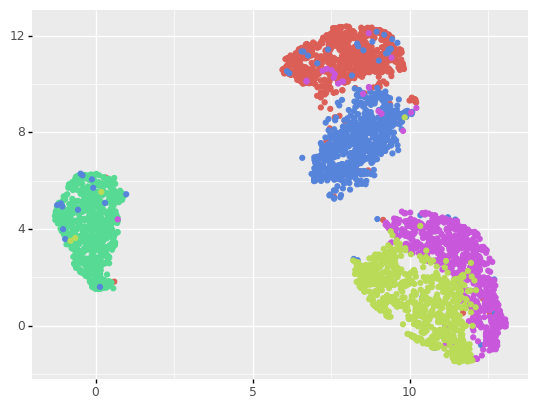

<ggplot: (144770965848)>

In [11]:
gg

### Sklearn LDA

In [12]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)

LinearDiscriminantAnalysis(store_covariance=True)

In [13]:
ret =  lda_grid(em, mapper)

(2500, 30)


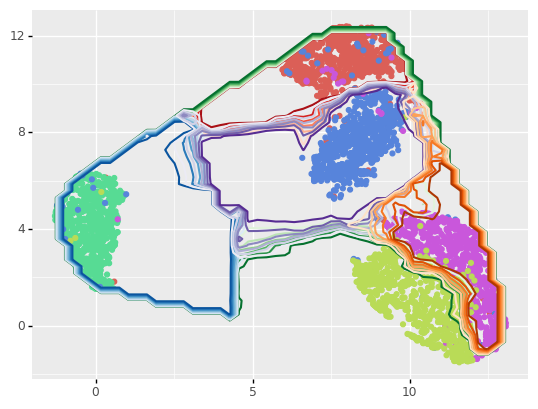

In [14]:
plot_contours_UMAP(gg, lda, *ret)

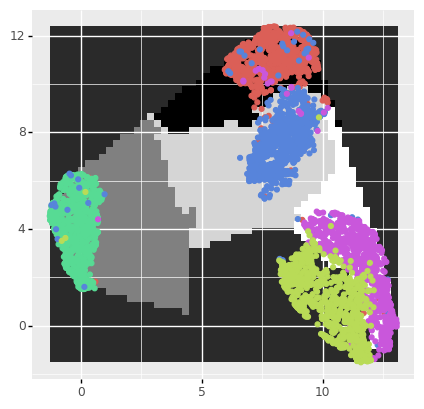

In [15]:
plot_regions_UMAP(gg, lda, *ret)

In [16]:
def print_metrics(true, pred):
    print(acc(true.astype(int), pred.astype(int)))
    print(metrics.confusion_matrix(true.astype(int), pred.astype(int)))

In [17]:
print_metrics(pd.Series(mnist_test_labels), lda.predict(mnist_test_pca))

0.908
[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


### Sklearn QDA

In [18]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), qda.predict(mnist_test_pca))

0.963
[[386   0   0  10   4]
 [  0 389   1   3   7]
 [  0   0 397   3   0]
 [ 14   0   1 378   7]
 [  5   6   1  12 376]]


In [175]:
class LDA():
    def __init__(self, method='distributional'):
        self.method = method
        self.K = None
        self.M = None
        self.ks = None #1xK
        self.priors = None #1xK
        self.coefficients = None #KxM
        self.intercepts = None #1xK
        self.parameters = None
        self.means = None #MxK
        self.covariances =  None #KxMxM
        self.pool_covs = True
    
    def _discriminants(self, X): #NxM -> KxN
        if (self.coefficients is None) or (self.intercepts is None):
            self.calculate_discriminant_params()
        assert((self.priors is not None) and (self.coefficients is not None) and (self.intercepts is not None))
        return self.coefficients.dot(X.T) + (self.intercepts + np.log(self.priors))[None,:].T
    
    def _bose_k(self):
        return np.array([0.5])
    
    def _mahalanobis(self, X, k=None): #NxM -> KxN
        ret = []
        r = range(self.K) if k is None else [k]
        for k in r:
            m = X - self.means[:,k]
            ret += [np.diag((X - self.means[:,k]) @ np.linalg.inv(self.covariances)[k,:,:] @ (X - self.means[:,k]).T)]
        return np.vstack(ret) if k is None else ret[0]
    
    def _general_discriminants(self, X): #KxN
        return -0.5*np.log(np.linalg.det(self.covariances))[:,None] - self._bose_k()[:,None] * self._mahalanobis(X)
    
    def _kth_likelihood(self, k):
        return stats.multivariate_normal(mean=self.means[:,k], cov=self.covariances[k,:,:])
    
    def _posteriors(self, X):
        r = [self._kth_likelihood(k).pdf(X) for k in range(self.means.shape[1])] #times priors!
        return np.array(r)
       
    def estimate_parameters(self, X): #NxM -> [1xM, MxM]
        return [X.mean(axis=0), np.cov(X.T)]
    
    def calculate_discriminant_params(self):
        cov_inv = np.linalg.inv(self.covariances[0,:,:])
        self.coefficients = self.means.T.dot(cov_inv)
        self.intercepts = -0.5*np.diag(self.means.T.dot(cov_inv.dot(self.means)))  
    
    def fit(self, X, y):
        self.ks = np.unique(y); self.K = len(self.ks); self.M = X.shape[1]
        classes = [X[np.where(y == k), :][0,:,:] for k in self.ks] #Kxn_kxM
        n = np.array([c.shape[0] for c in classes])
        self.parameters = [self.estimate_parameters(c) for c in classes]
        self.means = np.array([param[0] for param in self.parameters]).T
        self.covariances = np.array([param[1] for param in self.parameters])
        self.covariances = np.repeat(np.sum(n[:,None,None] * self.covariances, axis=0)[None,:],self.K,axis=0) / n.sum() \
                if self.pool_covs else self.covariances 
                    
        self.priors = n / n.sum()
        
        assert(n.sum() == X.shape[0])
        assert(self.M == self.covariances.shape[2])
        assert (self.priors.sum() == 1)
        return classes
    
    def _dk_from_method(self, X):
        if self.method=='distributional':
            return self._posteriors(X)
        elif self.method=='coeffs':
            return self._discriminants(X)
        elif self.method=='generalised':
            return self._general_discriminants(X)
                
    def predict(self, X):
        dk = self._dk_from_method(X)
        return self.ks[dk.argmax(axis=0)] 
       
    def predict_proba(self, X):
        dk = self._dk_from_method(X)
        if self.method!='distributional':
            dk = np.exp(dk)
        return (dk/dk.sum(axis=0)).T   

### Custom LDA (with Gaussians)

In [89]:
test_lda = LDA(method='generalised')

test_lda.fit(mnist_pca, mnist_labels)

print_metrics(pd.Series(mnist_test_labels), test_lda.predict(mnist_test_pca))

0.908
[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


In [176]:
class QDA(LDA):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False

### Custom QDA

In [91]:
test_qda = QDA(method='generalised')

test_qda.fit(mnist_pca, mnist_labels)

print_metrics(pd.Series(mnist_test_labels), test_qda.predict(mnist_test_pca))

0.963
[[386   0   0  10   4]
 [  0 389   1   3   7]
 [  0   0 397   3   0]
 [ 14   0   1 378   7]
 [  5   6   1  12 376]]


In [23]:
def fit_t(X, iter=200, eps=1e-6):
    N,D = X.shape
    cov = np.cov(X,rowvar=False)
    mean = X.mean(axis=0)
    mu = X - mean[None,:]
    dof = 3
    obj = []

    for i in range(iter):        
        
        # E step
        delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)
        z = (dof + D) / (dof + delta)
        
        obj.append(
            -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 \
            -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2)
        if len(obj) > 1 and np.abs(obj[-1] - obj[-2]) < eps: break
        
        # M step
        mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum()
        mu = X - mean.squeeze()[None,:]
        cov = np.einsum('ij,ik->jk', mu, mu * z[:,None])/N
        d_t = (np.log(z) + special.digamma((dof + D)/2) - np.log((dof + D)/2) - z).sum()
        dof_obj = lambda v: -( -N*special.gammaln(v/2) + N*v*np.log(v/2)/2 + v*d_t/2 )
        dof_grad = lambda v: -(N/2 * (-special.digamma(v/2) + np.log(v/2) + 1) + d_t/2)        
        dof = optimize.minimize(dof_obj, dof, jac=dof_grad, bounds=[(0,None)]).x

    return mean.squeeze(), cov, dof

In [124]:
class t_LDA(LDA):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.dofs = None #1xK
    
    def _kth_likelihood(self, k):
        return stats.multivariate_t(loc=self.means[:,k], shape=self.covariances[k,:,:], df=self.dofs[k])
    
    def estimate_parameters(self, X):
        return fit_t(X)
    
    def _bose_k(self):
        return (0.5*(1 + self.M/self.dofs))
    
    def _discriminants(self, X): #NxM -> KxN
        return None
        
    def _general_discriminants(self, X):
        v = self.dofs
        return super()._general_discriminants(X) + (special.gammaln((v+self.M)/2) - special.gammaln(v/2) - 0.5*self.M*np.log(v))[:,None]
            
    def fit(self, X,y):
        super().fit(X,y)
        self.dofs = np.array([param[2] for param in self.parameters]).squeeze()

### t-LDA fitting (mostly redundant: pooling covs still means discriminant depends on x^2 because of differing dofs (assuming same dofs = MMD classifier)

In [126]:
test_t_lda = t_LDA(method='generalised')

test_t_lda.fit(mnist_pca, mnist_labels)
#test_t_lda.dofs = np.ones((test_t_lda.K)) * 0.5
print_metrics(pd.Series(mnist_test_labels), test_t_lda.predict(mnist_test_pca))

0.7195
[[388   8   2   2   0]
 [  0 399   0   1   0]
 [  7  93 296   4   0]
 [ 76  48   1 275   0]
 [ 13 300   1   5  81]]


In [128]:
class t_QDA(t_LDA):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False

### t-QDA

In [131]:
test_t_qda = t_QDA(method='generalised')

test_t_qda.fit(mnist_pca, mnist_labels)

print_metrics(pd.Series(mnist_test_labels), test_t_qda.predict(mnist_test_pca))

0.8735
[[396   0   0   4   0]
 [  3 396   0   1   0]
 [ 15  10 364  11   0]
 [ 45   5   0 350   0]
 [ 17 128   0  14 241]]


(2500, 30)


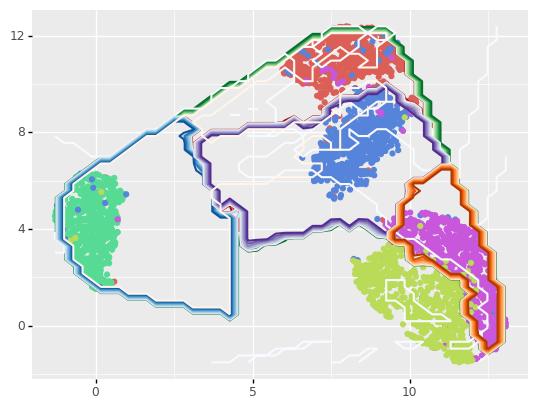

In [132]:
plot_contours_UMAP(gg, test_t_qda, *ret)

In [229]:
class GQDA(QDA):
    def __init__(self):
        super().__init__(method='generalised')
        self.c = None
    
    
    #def estimate_parameters(self, X):
    #    return fit_t(X)
    #GQDA: use normal estimators for now!
    
    def fit(self, X,y):
        classes = super().fit(X,y) #Kx[n_k, M]
        uijs = [np.zeros((classes[k].shape[0], self.K, self.K)) for k in range(self.K)] #Kx[n_kxIxJ]
        sij = np.zeros((self.K,self.K))
        logdets = np.log(np.linalg.det(self.covariances)) #K,  
        for i in range(self.K):
            for j in range(self.K):
                dij_on_i = self._mahalanobis(classes[i], k=j) - self._mahalanobis(classes[i], k=i) #Kxn_i
                dij_on_j = self._mahalanobis(classes[j], k=j) - self._mahalanobis(classes[j], k=i) #Kxn_j
                sij[i,j] = logdets[j] - logdets[i]
                
                
                uijs[i][:, i, j] = dij_on_i / sij[i,j]
                uijs[i][:, j, j] = np.inf
                uijs[j][:, i, j] = dij_on_j / sij[i,j]
                
        
        T = []
        for uij in uijs:
            T.append(uij[(uij > 0) * (uij<1)])
        T = np.sort(np.concatenate(T))
        T = np.concatenate([np.array([0]), T])
        print(T)
        MCc = np.zeros((len(T)))
        for e,c in enumerate(T):
            
            for i in range(self.K):
                Rijc = []
                for j in range(self.K):
                    if i==j: continue
                    p = uijs[i][:, i,j]
                    to_app = p > -c if sij[i,j]>0 else p < -c 
                    Rijc.append(classes[i][to_app])
                Rijc = np.vstack(Rijc)
                Ric = np.unique(Rijc, axis=0)
                #print(Ric.shape, Rijc.shape)
                lenRic = Ric.shape[0]
                MCic = classes[i].shape[0] - lenRic
                #print(MCic, Ric.shape)
                MCc[e] += MCic
                
        return uijs, MCc, T
        
        def predict(self, X, c=self.c):
            
        

In [230]:
test_gqda = GQDA()
uijs,MCc,T=test_gqda.fit(mnist_pca, mnist_labels)

<ipython-input-229-7a1e1b122d5b>:22: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-229-7a1e1b122d5b>:24: RuntimeWarning: invalid value encountered in true_divide


[0.         0.00212998 0.00212998 0.01584444 0.01584444 0.0283971
 0.0283971  0.03289227 0.03289227 0.04491095 0.04491095 0.05474851
 0.05474851 0.06229231 0.06229231 0.10447597 0.10447597 0.11309858
 0.11309858 0.12595282 0.12595282 0.1378177  0.1378177  0.14323512
 0.14323512 0.14412004 0.14412004 0.15109267 0.15109267 0.15854355
 0.15854355 0.16675557 0.16675557 0.17590923 0.17590923 0.18523869
 0.18523869 0.2056389  0.2056389  0.21223787 0.21223787 0.22003867
 0.22003867 0.22971476 0.22971476 0.23141023 0.23141023 0.23258928
 0.23258928 0.242114   0.242114   0.25082097 0.25082097 0.26222297
 0.26222297 0.27810697 0.27810697 0.28036341 0.28036341 0.28179828
 0.28179828 0.28794576 0.28794576 0.30359871 0.30359871 0.31450313
 0.31450313 0.32874191 0.32874191 0.34113463 0.34113463 0.349533
 0.349533   0.36194673 0.36194673 0.37188187 0.37188187 0.37772622
 0.37772622 0.37809315 0.37809315 0.38856992 0.38856992 0.41800912
 0.41800912 0.42879786 0.42879786 0.43718096 0.43718096 0.4400276

In [231]:
print(MCc)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [232]:
print(T)

[0.         0.00212998 0.00212998 0.01584444 0.01584444 0.0283971
 0.0283971  0.03289227 0.03289227 0.04491095 0.04491095 0.05474851
 0.05474851 0.06229231 0.06229231 0.10447597 0.10447597 0.11309858
 0.11309858 0.12595282 0.12595282 0.1378177  0.1378177  0.14323512
 0.14323512 0.14412004 0.14412004 0.15109267 0.15109267 0.15854355
 0.15854355 0.16675557 0.16675557 0.17590923 0.17590923 0.18523869
 0.18523869 0.2056389  0.2056389  0.21223787 0.21223787 0.22003867
 0.22003867 0.22971476 0.22971476 0.23141023 0.23141023 0.23258928
 0.23258928 0.242114   0.242114   0.25082097 0.25082097 0.26222297
 0.26222297 0.27810697 0.27810697 0.28036341 0.28036341 0.28179828
 0.28179828 0.28794576 0.28794576 0.30359871 0.30359871 0.31450313
 0.31450313 0.32874191 0.32874191 0.34113463 0.34113463 0.349533
 0.349533   0.36194673 0.36194673 0.37188187 0.37188187 0.37772622
 0.37772622 0.37809315 0.37809315 0.38856992 0.38856992 0.41800912
 0.41800912 0.42879786 0.42879786 0.43718096 0.43718096 0.4400276

## Synthetic Data

In [133]:
df=1.5

In [134]:
X1 = stats.multivariate_t(loc=np.array([1,1]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X2 = stats.multivariate_t(loc=np.array([5,-4]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X3 = stats.multivariate_t(loc=np.array([7,7]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X = np.vstack([X1, X2, X3])

In [135]:
y = np.hstack([np.zeros((1000)), np.ones((1000)), 2*np.ones((1000))])

In [136]:
X1_test = stats.multivariate_t(loc=np.array([1,1]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X2_test = stats.multivariate_t(loc=np.array([5,-4]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X3_test = stats.multivariate_t(loc=np.array([7,7]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=df).rvs(size=1000)
X_test = np.vstack([X1_test, X2_test, X3_test])

In [137]:
def plot_contours(X, f, ax):
    AA, BB = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 50),
                 np.linspace(X[:,1].min(), X[:,1].max(), 50))
    cmaps = ['Reds','Greens','Blues','Purples','Oranges']
    grid = np.c_[AA.ravel(), BB.ravel()]
    cnt = f(grid)
    for i in range(cnt.shape[1]):
        ax.contour(AA, BB, cnt[:,i].reshape(AA.shape), cmap=cmaps[i])#, [0.5])
        ax.contour(AA, BB, cnt[:,i].reshape(AA.shape), levels=[0.5], linewidths=3)#, [0.5])

<ipython-input-88-e46bb3f4a1a7>:81: RuntimeWarning: invalid value encountered in true_divide


0.899
[[888  61  51]
 [ 47 889  64]
 [ 66  14 920]]
[[ 1.43065256  4.39843032  6.55120129]
 [ 1.70993939 -3.80689578  6.61874387]]


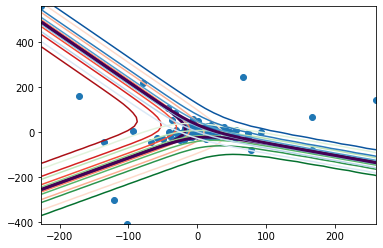

In [138]:
ldatest = LDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
ldatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, ldatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), ldatest.predict(X_test))
print(ldatest.means)

0.598
[[820  11 169]
 [142  34 824]
 [ 50  10 940]]
[[ 1.43065256  4.39843032  6.55120129]
 [ 1.70993939 -3.80689578  6.61874387]]


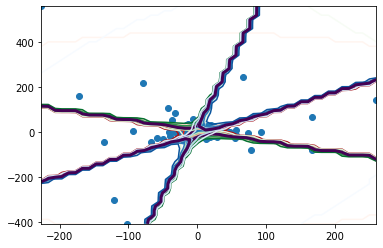

In [139]:
qdatest = QDA(method='generalised')#discriminant_analysis.QuadraticDiscriminantAnalysis()
qdatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, qdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), qdatest.predict(X_test))
print(qdatest.means)

<ipython-input-88-e46bb3f4a1a7>:81: RuntimeWarning: invalid value encountered in true_divide


0.9093333333333333
[[877  62  61]
 [ 48 919  33]
 [ 48  20 932]]
[[ 1.09769419  5.06055074  6.85918314]
 [ 0.96681846 -4.01615974  6.99802993]]


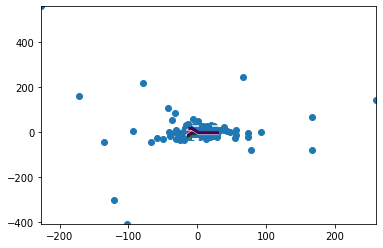

In [140]:
t_ldatest = t_LDA(method='generalised')
t_ldatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, t_ldatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), t_ldatest.predict(X_test))
print(t_ldatest.means)

<ipython-input-88-e46bb3f4a1a7>:81: RuntimeWarning: invalid value encountered in true_divide


0.911
[[883  57  60]
 [ 53 915  32]
 [ 48  17 935]]


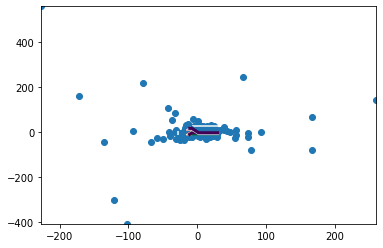

In [141]:
t_qdatest = t_QDA(method='generalised')
t_qdatest.fit(X, pd.Series(y))
plt.scatter(X[:,0],X[:,1])
plot_contours(X, t_qdatest.predict_proba, plt.gca())
print_metrics(pd.Series(y), t_qdatest.predict(X_test)) #exact

In [234]:
test_gqda = GQDA()
uijs,MCc,T=test_gqda.fit(X, pd.Series(y))

<ipython-input-229-7a1e1b122d5b>:22: RuntimeWarning: invalid value encountered in true_divide
<ipython-input-229-7a1e1b122d5b>:24: RuntimeWarning: invalid value encountered in true_divide


[0.00000000e+00 3.83866832e-04 3.83866832e-04 ... 9.87583435e-01
 9.91535571e-01 9.91535571e-01]


In [235]:
print(MCc)

[132. 132. 132. ... 957. 957. 957.]


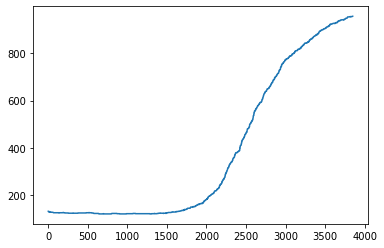

In [236]:
plt.plot(MCc)

In [237]:
MCc.argmin()

641

In [238]:
T[MCc.argmin()]

0.0932326827546953